# 2D advection PINN 

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import os
import imageio

# Define the Neural architecture

In [5]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, dropout_rate=1e-3):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            activation(),
            nn.Dropout(dropout_rate)
        )
        self.fch = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Linear(N_HIDDEN, N_HIDDEN),
                    activation(),
                    nn.Dropout(dropout_rate)
                ) for _ in range(N_LAYERS-1)
            ]
        )
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        
        return x

# Advection equation 

$ -\left( v(x) \frac{\partial u}{\partial x} + v(y) \frac{\partial u}{\partial y} \right)$


# u0 = gaussian pulse | u2d has added y component


In [118]:
mu = 0.1 
def u0(x):
    return np.exp(-100*(x-0.2)**2)
def u_true(x,t):
    return  u0(x - mu * t)
def u_2d_true(x, y, t):
        return u0(x - mu * t) * u0(y - mu * t)

# Check input in x-y plot

(100, 1)


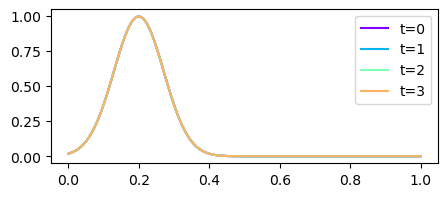

In [117]:
xx = np.linspace(0, 1, 100).reshape(-1,1)
print(xx.shape)
plt.figure(figsize=(5,2))
for tt in range(4):
    plt.plot(xx, u_true(xx, 0), '-', color=cm.rainbow(tt/4), label="t="+str(tt))
plt.legend()            
plt.show()

# Check input in contour plot

x shape is (40, 40)
t values shape is (5,)
U shape is (40, 40)


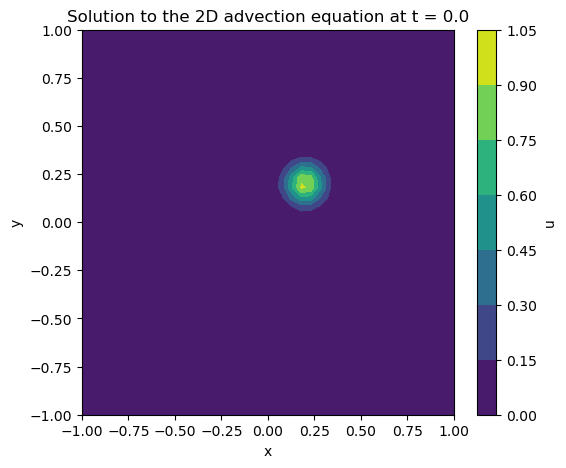

U shape is (40, 40)


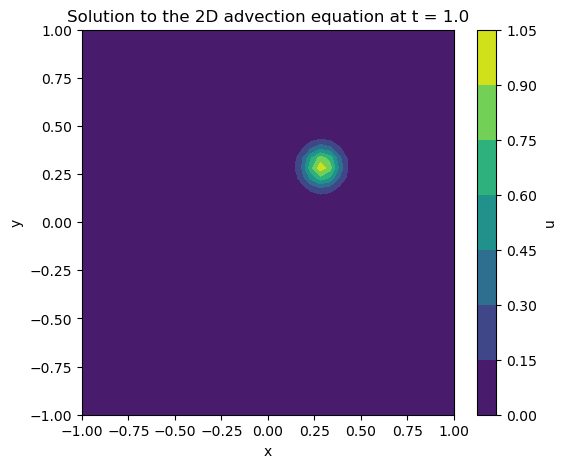

U shape is (40, 40)


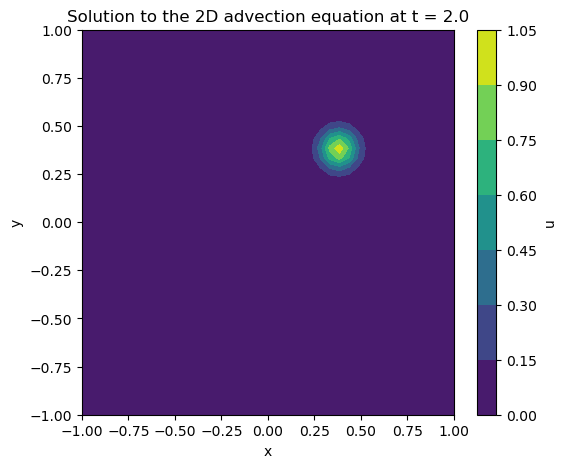

U shape is (40, 40)


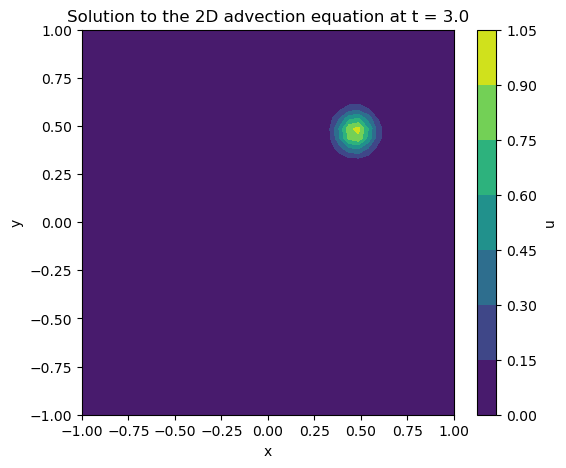

U shape is (40, 40)


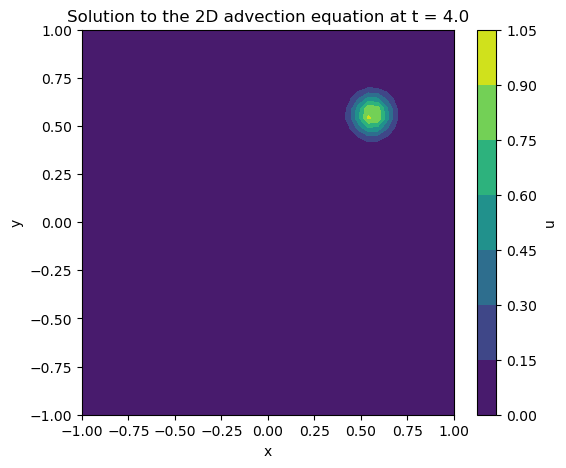

In [26]:
# Define the spatial and temporal coordinates
x = np.linspace(-1, 1, 40)
y = np.linspace(-1, 1, 40)

# Create a meshgrid of the spatial coordinates
X, Y = np.meshgrid(x, y)
print('x shape is', X.shape)
# Define the time values
t_values = np.linspace(0, 4, 5)
print('t values shape is', t_values.shape)
# Plot the solution for each time value
for t in t_values:
    # Compute the solution at the given time
    U = u_2d_true(X, Y, t)
    print('U shape is',U.shape)
    # Plot the solution
    plt.figure(figsize=(6, 5))
    plt.contourf(X, Y, U, cmap='viridis')
    plt.colorbar(label='u')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Solution to the 2D advection equation at t = {}'.format(t))
    plt.show()


# Define training data [xyt_data] and loss [u_data]

In [76]:
nx,ny, nt = 40, 40,2

xyt_data = np.hstack((
    np.repeat([np.linspace(-1, 1, nx) ], nt, axis=0).reshape(-1,1),
    np.repeat([np.linspace(-1, 1, ny) ], nt, axis=0).reshape(-1,1),
    np.repeat([np.linspace(0,nt-1,nt)], nx, axis=0).reshape(-1,1)))

X_t,Y_t = np.meshgrid(xyt_data[:,0], xyt_data[:,1])
# print(X_t.shape, Y_t.shape)
# print(xyt_data[:,0].shape)
#print(X_t.shape, Y_t.shape, xyt_data[:,2].shape)

u_data = u_2d_true(X_t,Y_t, xyt_data[:,2])
#print(u_data.shape)
Pyt_data = np.hstack((X_t.reshape(-1,1), Y_t.reshape(-1,1),np.repeat( [xyt_data[:,2]],nx*nt,axis=0).reshape(-1,1)))
xyt_data = torch.tensor(xyt_data).float()
Pyt_data = torch.tensor(Pyt_data).float()
#print(xyt_data.shape)
u_data = torch.tensor(u_data).float().reshape(-1,1)
print(u_data.shape)
print(Pyt_data.shape, u_data.shape)

N_OUTPUT = nx*nt


torch.Size([6400, 1])
torch.Size([6400, 3]) torch.Size([6400, 1])


# plot the tensor form of input data and loss function 

(40, 40)
(40, 40) (40, 40)
torch.Size([6400, 1])
(80, 80)


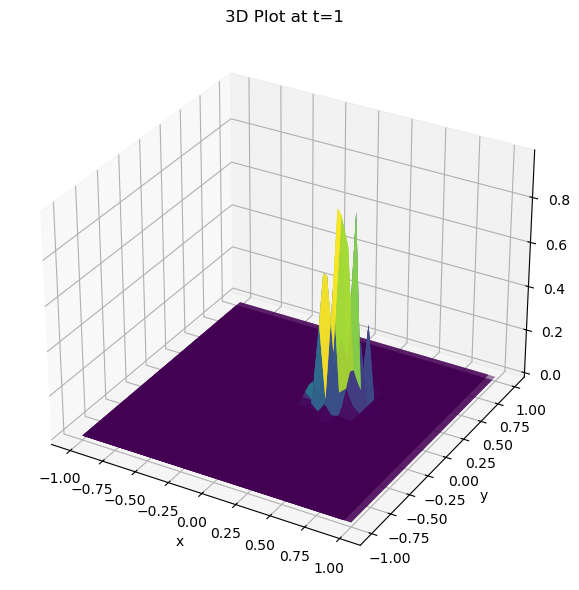

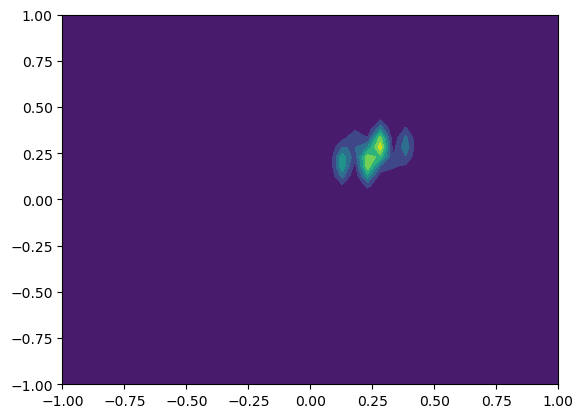

In [119]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ttt= xyt_data[:,2].numpy()
print(u_2d_true(X, Y, 0).shape)
# Plot for t=0
# ax.plot_surface(X, Y, u_2d_true(X, Y, ttt), cmap='viridis', alpha=0.5)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('u')
# ax.set_title('3D Plot at t=0')

print(X.shape, Y.shape)
xt ,yt = np.meshgrid(xyt_data[:,0].detach().numpy(), xyt_data[:,1].detach().numpy())
print(u_data.shape)
uuu = u_data.detach().numpy().reshape(80,80)
print(uuu.shape)
# Plot for t=1
ax.plot_surface(xt, yt,uuu , cmap='viridis', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
ax.set_title('3D Plot at t=1')

plt.tight_layout()
plt.show()
plt.contourf(xt,yt, uuu, cmap='viridis')

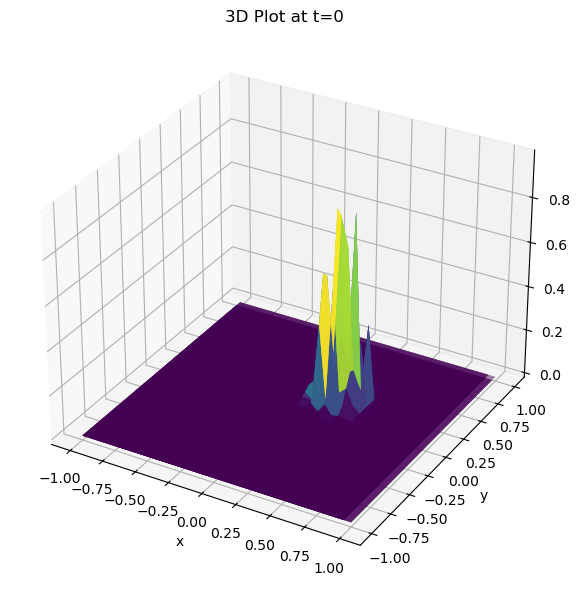

In [31]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot for t=0
X1, Y1 = np.meshgrid(xyt_data[:,0], xyt_data[:,1])
ax.plot_surface(X1,Y1,u_2d_true(X_t,Y_t,ttt), cmap='viridis', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
ax.set_title('3D Plot at t=0')







plt.tight_layout()
plt.show()

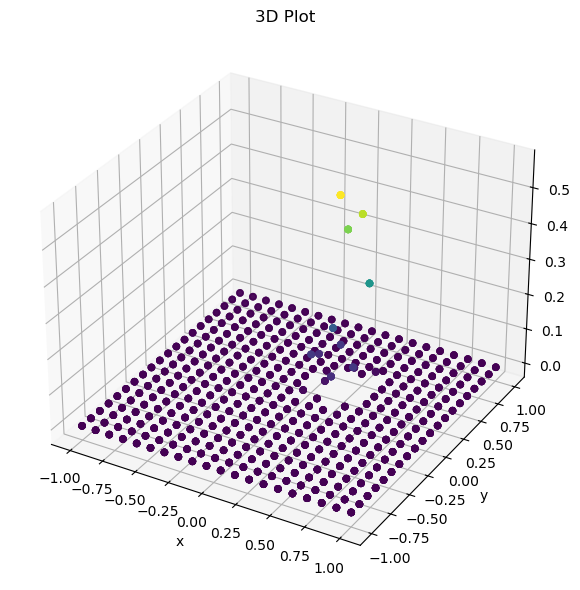

In [133]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot for tt in range 2
for tt in range(2):
    ax.scatter(X1, Y1, u_data.detach().numpy().squeeze(), c=u_data.detach().numpy().squeeze(), cmap='viridis')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
ax.set_title('3D Plot')

plt.tight_layout()
plt.show()

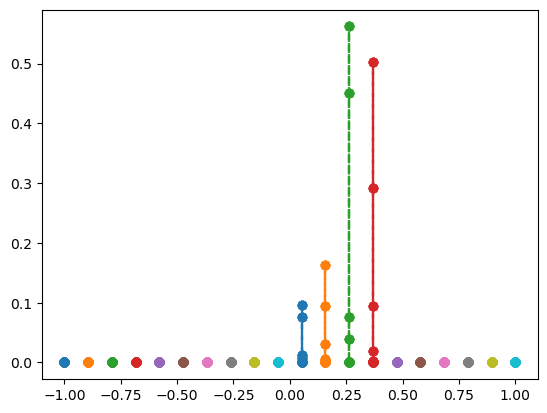

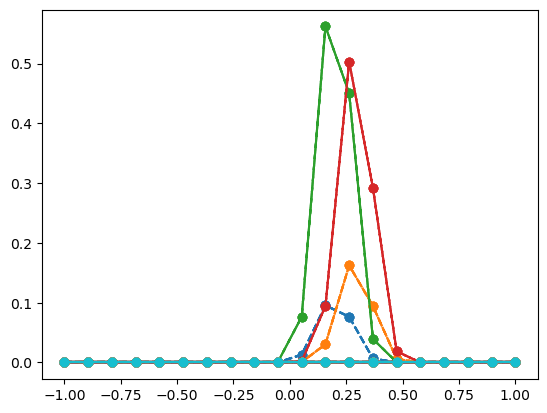

In [134]:
plt.plot(X1, u_data.detach().numpy(), '--o')
plt.show()

plt.plot(Y1, u_data.detach().numpy(), '--o')
plt.show()

# Define parameters of Neural Network

In [120]:
torch.manual_seed(123)
# N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS
model = FCN(3,1,128,3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for i in range(1000):
    optimizer.zero_grad()
    uh = model(Pyt_data)  # Transpose the input matrix
    
    loss = torch.mean((uh-u_data)**2)
    loss.backward()
    optimizer.step()

# Test model 

In [121]:

xyt_test = np.hstack((
    np.repeat([np.linspace(-1, 1, nx) ], nt, axis=0).reshape(-1,1),
    np.repeat([np.linspace(-1, 1, ny) ], nt, axis=0).reshape(-1,1),
    np.repeat([np.linspace(0,nt-1,nt)], nx, axis=0).T.reshape(-1,1)))

X_t,Y_t = np.meshgrid(xyt_data[:,0], xyt_data[:,1])

Pyt_test = np.hstack((X_t.reshape(-1,1), Y_t.reshape(-1,1),np.repeat( [xyt_data[:,2]],nx*nt,axis=0).reshape(-1,1)))
xyt_test = torch.tensor(xyt_data).float().reshape(-1,3)
Pyt_test = torch.tensor(Pyt_data).float().reshape(-1,3)
print(model(xyt_test).detach().numpy().shape)
cwd = os.getcwd()
true_plot_dir = os.path.join(cwd, '2d-advection', 'true_plot')
nn_plot_dir = os.path.join(cwd, '2d-advection', 'nn_plot')
 # Create the directories if they don't exist
os.makedirs(nn_plot_dir, exist_ok=True)
os.makedirs(true_plot_dir, exist_ok=True)
#Generate and save the plots for tt = 0-11
for tt in range(12):
    xyt_test[:, 2] = tt
    col = cm.rainbow(tt / 5)
    u_test = u_2d_true(X_t, Y_t, xyt_test[:, 2].numpy())

    m = model(Pyt_test).detach().numpy().reshape(80, 80)
    print(m.shape)
    
    # Plot and save the nn plot
    plt.contourf(X_t, Y_t,m , cmap='viridis', alpha=0.5)
    plt.colorbar(label='u')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('NN Plot at t = {}'.format(tt))
    plt.savefig(nn_plot_dir + '/nn_plot_{}.png'.format(tt))
    plt.close()
    
    # Plot and save the true plot
    plt.contourf(X_t, Y_t, u_test, cmap='viridis', alpha=0.5)
    plt.colorbar(label='u')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('True Plot at t = {}'.format(tt))
    plt.savefig(true_plot_dir + '/true_plot_{}.png'.format(tt))
    plt.close()

/tmp/ipykernel_6144/4086125526.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyt_test = torch.tensor(xyt_data).float().reshape(-1,3)
/tmp/ipykernel_6144/4086125526.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Pyt_test = torch.tensor(Pyt_data).float().reshape(-1,3)


(80, 1)
(80, 80)
(80, 80)
(80, 80)
(80, 80)
(80, 80)
(80, 80)
(80, 80)
(80, 80)
(80, 80)
(80, 80)
(80, 80)
(80, 80)


# Save GIF

In [122]:

for _ in ['nn_plot', 'true_plot']:
    # Set the directories for the images
    plot_dir = os.path.join(cwd, '2d-advection', _)

    # Get the list of image files
    plot_files = sorted([os.path.join(plot_dir, file) for file in os.listdir(plot_dir)])

    # Create a list to store the images
    images = []

    # Read and append the images to the list
    for file in plot_files:
        images.append(imageio.imread(file))

    # Set the output file path
    output_file = os.path.join(cwd, "2d{}.gif".format(_))

    # Save the images as a GIF
    imageio.mimsave(output_file, images, duration=0.5)



/tmp/ipykernel_6144/1997301079.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file))


# Define physics sampling points

In [133]:
# randomly sample points in x,y-t space, where x & y in [0,1] and t in [0,11]
np.random.seed(123)
xyt_physics = np.random.uniform(size=(6400,3))
print(xyt_physics.shape)
xyt_physics[:,2] *= 4
xyt_physics = torch.tensor(xyt_physics).float().requires_grad_(True)

(6400, 3)


# Define neural network parameters and train 

In [143]:
torch.manual_seed(123)
# N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS
pinn = FCN(3,1,128,24)

optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
for i in range(10000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    uh = pinn(Pyt_data)
    
    loss1 = torch.mean((uh-u_data)**2) # use mean squared error
    
    # compute the "physics loss"
    uhp = pinn(xyt_physics)
    grad = torch.autograd.grad(outputs=uhp, inputs=xyt_physics, 
                               grad_outputs=torch.ones_like(uhp), create_graph=True)[0]
    dudx = grad[:, 0]
    dudy = grad[:, 1]
    dudt = grad[:, 2]
    physics = dudt + mu * dudx + mu * dudy # this term is zero if the model output satisfies the advection equation
    loss2 = torch.mean(physics**2)
    loss2 *= 1e5 # multiply by a large number to make it comparable to loss1
    # backpropagate combined loss
    loss =  loss1 + loss2 # add two loss terms together
    loss.backward()
    optimizer.step()

    if (i+1) % 1000 == 0:
            print(f'Epoch: {i+1}/{10000}, Loss: {loss.item()}')
            print(f'Loss 1: {loss1.item()}, Loss 2: {loss2.item()}')
            

Epoch: 1000/10000, Loss: 0.0037011909298598766
Loss 1: 0.0037011909298598766, Loss 2: 4.2141675836024556e-17
Epoch: 2000/10000, Loss: 0.0036931068170815706
Loss 1: 0.0036931068170815706, Loss 2: 1.8587400182389224e-17
Epoch: 3000/10000, Loss: 0.003697778331115842
Loss 1: 0.003697778331115842, Loss 2: 2.3227707229341235e-18
Epoch: 4000/10000, Loss: 0.0037008323706686497
Loss 1: 0.0037008323706686497, Loss 2: 4.1545266206664635e-18
Epoch: 5000/10000, Loss: 0.0036960733123123646
Loss 1: 0.0036960733123123646, Loss 2: 1.285737697698843e-18


KeyboardInterrupt: 

# Test Pinn

In [144]:
xyt_test = np.hstack((
    np.repeat([np.linspace(-1, 1, nx) ], nt, axis=0).reshape(-1,1),
    np.repeat([np.linspace(-1, 1, ny) ], nt, axis=0).reshape(-1,1),
    np.repeat([np.linspace(0,nt-1,nt)], nx, axis=0).T.reshape(-1,1)))

X_t,Y_t = np.meshgrid(xyt_data[:,0], xyt_data[:,1])

Pyt_test = np.hstack((X_t.reshape(-1,1), Y_t.reshape(-1,1),np.repeat( [xyt_data[:,2]],nx*nt,axis=0).reshape(-1,1)))
xyt_test = torch.tensor(xyt_data).float().reshape(-1,3)
Pyt_test = torch.tensor(Pyt_data).float().reshape(-1,3)
print(X_t.shape,pinn(xyt_test).detach().numpy().shape)
cwd = os.getcwd()
true_plot_dir = os.path.join(cwd, '2d-advection', 'true_plot')
nn_plot_dir = os.path.join(cwd, '2d-advection', 'pinn_plot')
 # Create the directories if they don't exist
os.makedirs(nn_plot_dir, exist_ok=True)
os.makedirs(true_plot_dir, exist_ok=True)
#Generate and save the plots for tt = 0-11
for tt in range(10):
    xyt_test[:, 2] = tt
    col = cm.rainbow(tt / 5)
    u_test = u_2d_true(X_t, Y_t, xyt_test[:, 2].numpy())
    m = pinn(Pyt_test).detach().numpy().reshape(80, 80)
    # Plot and save the nn plot
    plt.contourf(X_t, Y_t, m, cmap='viridis', alpha=0.5)
    plt.colorbar(label='u')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('NN Plot at t = {}'.format(tt))
    plt.savefig(nn_plot_dir + '/pinn_plot_{}.png'.format(tt))
    plt.close()
    
    # Plot and save the true plot
    plt.contourf(X_t, Y_t, u_test, cmap='viridis', alpha=0.5)
    plt.colorbar(label='u')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('True Plot at t = {}'.format(tt))
    plt.savefig(true_plot_dir + '/true_plot_{}.png'.format(tt))
    plt.close()
    print('done',tt)



/tmp/ipykernel_6144/2394401996.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyt_test = torch.tensor(xyt_data).float().reshape(-1,3)
/tmp/ipykernel_6144/2394401996.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Pyt_test = torch.tensor(Pyt_data).float().reshape(-1,3)


(80, 80) (80, 1)
done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9


# Save Pinn

In [145]:
for _ in ['pinn_plot', 'true_plot']:
    # Set the directories for the images
    plot_dir = os.path.join(cwd, '2d-advection', _)

    # Get the list of image files
    plot_files = sorted([os.path.join(plot_dir, file) for file in os.listdir(plot_dir)])

    # Create a list to store the images
    images = []

    # Read and append the images to the list
    for file in plot_files:
        images.append(imageio.imread(file))

    # Set the output file path
    output_file = os.path.join(cwd, "2d{}.gif".format(_))

    # Save the images as a GIF
    imageio.mimsave(output_file, images, duration=4)


/tmp/ipykernel_6144/3783057286.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file))
